In [ ]:
# !pip install -U --force-reinstall numpy matplotlib pyzmq jinja2 ipython

In [17]:
# ImportError: cannot import name 'encode_utf8' from 'bokeh.util.string'
# ! pip install panel==0.9.3

In [12]:
# !pip install datashader

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
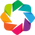

In [13]:
import pickle
import numpy as np
import pandas as pd
import holoviews as hv
import networkx as nx
from holoviews import opts
from holoviews.operation.datashader import datashade, bundle_graph
from py2neo import Node, Relationship, Graph, Database, Subgraph

hv.extension('bokeh')

defaults = dict(width=400, height=400)
hv.opts.defaults(
    opts.EdgePaths(**defaults), opts.Graph(**defaults), opts.Nodes(**defaults))

In [14]:
import py2neo
py2neo.__version__

'4.3.0'

In [15]:
con = pd.read_csv('data/concepts.csv')
sem = pd.read_csv('data/semantype.csv')
rel = pd.read_csv('data/relations.csv')

In [29]:
# CUI <> TUI: n to n
sem[sem['CUI']=='C0000294']

,CUI,TUI,STN,STY
247667,C0000294,T121,A1.4.1.1.1,Pharmacologic Substance
261682,C0000294,T109,A1.4.1.2.1,Organic Chemical


In [30]:
# # SUI is unique
# con['SUI'].nunique()

In [31]:
# # CUI is not unique
# con['CUI'].nunique()

In [32]:
# sem[sem.duplicated(['CUI'])]

In [33]:
# sem[sem['CUI'] == 'C0054208']

In [34]:
default_db = Database(password="123456")

In [35]:
default_db.name

'graph.db'

In [36]:
graph = Graph(user="neo4j", password="123456")

In [37]:
graph.delete_all()

In [38]:
# graph.schema.drop_uniqueness_constraint('SCUI', 'name')
# graph.schema.drop_uniqueness_constraint('CUI', 'name')
# graph.schema.drop_uniqueness_constraint('TUI', 'name')

In [39]:
con.head()

,CUI,TS,STT,SUI,ISPREF,SCUI,CODE,STR
0,C0319824,S,PF,S3204998,Y,420643001,420643001,Caloscypha fulgens (organism)
1,C0006864,S,PF,S3205841,Y,421921003,421921003,Cannabinoid (substance)
2,C0201945,S,PF,S3213573,Y,77161005,77161005,Cerebrospinal fluid protein electrophoresis (p...
3,C0013336,S,PF,S3235999,Y,422065006,422065006,Constitutional short stature (disorder)
4,C0600203,S,PF,S3257200,Y,421675006,421675006,Dichloroacetic acid (substance)


In [40]:
con['STYPE'] = con['STR'].apply(lambda x: x[x.index('(')+1: x.index(')')])

In [41]:
con.head()

,CUI,TS,STT,SUI,ISPREF,SCUI,CODE,STR,STYPE
0,C0319824,S,PF,S3204998,Y,420643001,420643001,Caloscypha fulgens (organism),organism
1,C0006864,S,PF,S3205841,Y,421921003,421921003,Cannabinoid (substance),substance
2,C0201945,S,PF,S3213573,Y,77161005,77161005,Cerebrospinal fluid protein electrophoresis (p...,procedure
3,C0013336,S,PF,S3235999,Y,422065006,422065006,Constitutional short stature (disorder),disorder
4,C0600203,S,PF,S3257200,Y,421675006,421675006,Dichloroacetic acid (substance),substance


In [42]:
# con['CUI_Node'] = con.apply(lambda row: build_nodes(row, 'CUI', 'CUI'), axis=1)
# con['SCUI_Node'] = con.apply(lambda row: build_nodes(row, 'SCUI', 'SCUI', ['STR', 'STYPE']), axis=1)

In [43]:
g = con.groupby('CUI')['STR'].apply(lambda x: ' | '.join(list(np.unique(x))))

In [44]:
cui_df = g.reset_index()

In [45]:
cui_df.head()

,CUI,STR
0,C0000052,"1,4-alpha-Glucan branching enzyme (substance)"
1,C0000097,Methylphenyltetrahydropyridine (substance)
2,C0000102,1-Naththylamine (substance)
3,C0000163,17-Hydroxycorticosteroid (substance)
4,C0000167,17-Ketosteroid (substance)


In [46]:
%%time
cuis = {}
# batch_size = 200
for index, row in cui_df.iterrows():
    cui_name = str(row['CUI'])
    props = {'STR': row['STR']}
    cui = {'name': cui_name, 'props': props}
    cuis[cui_name] = (cui)

CPU times: user 49.1 s, sys: 536 ms, total: 49.6 s
Wall time: 49.7 s


In [47]:
%%time
graph.schema.create_uniqueness_constraint('CUI', 'name')
statement = '''
UNWIND {batches} as batch
MERGE(a:CUI {name:batch.name})
ON CREATE SET a+=batch.props
'''
result = graph.run(statement, batches=list(cuis.values()))

CPU times: user 9.37 s, sys: 452 ms, total: 9.82 s
Wall time: 28.7 s


In [48]:
%%time
graph.schema.create_uniqueness_constraint('SCUI', 'name')
scuis = {}

for index, row in con.iterrows():
    scui_name = str(row['SCUI'])
    if scui_name not in scuis:
        props = {'STR': row['STR'], 'STYPE': row['STYPE'], 'SAB': 'SNOMEDCT_US'}
        scui = {'name': scui_name, 'props': props}
        scuis[scui_name] = (scui)

CPU times: user 56.4 s, sys: 684 ms, total: 57.1 s
Wall time: 57.2 s


In [49]:
%%time
statement = '''
UNWIND {batches} as batch
MERGE(a:SCUI {name:batch.name})
ON CREATE SET a+=batch.props
'''
result = graph.run(statement, batches=list(scuis.values()))

CPU times: user 12.2 s, sys: 432 ms, total: 12.6 s
Wall time: 38.2 s


In [50]:
# %%time
# # Set node attributes
# # MATCH (n { name: 'Andy' })
# # SET n.surname = 'Taylor'
# statement = '''
# UNWIND {batches} as batch
# MATCH(n:SCUI {name:batch.name})
# SET n.SAB = 'SNOMEDCT_US'
# '''
# result = graph.run(statement, batches=list(scuis.values()))

In [51]:
%%time
# SCUI-->CUI is a 1:n relation
rels = []
statement_relations = '''
UNWIND {batches} as batch
MATCH (u:SCUI {name:batch.scui}), (r:CUI {name:batch.cui})
MERGE (u)-[:scui_to_cui]->(r)
'''
# MERGE (r)-[:cui_to_scui]->(u)
batch_size = 2000
for index, row in con.iterrows(): 
    rels.append({'scui': str(row['SCUI']), 'cui': row['CUI']})
    
    if index%batch_size == 0:        
        result = graph.run(statement_relations, batches=rels)
        rels = []
result = graph.run(statement_relations, batches=rels)

CPU times: user 1min 22s, sys: 244 ms, total: 1min 22s
Wall time: 2min 13s


In [ ]:
# graph.schema.drop_uniqueness_constraint('SCUI', 'id')

In [16]:
rel.shape

(2239172, 7)

In [17]:
# Two concepts can have two different relationships
rel[rel.duplicated(['CUI1', 'CUI2', 'RELA'])]

,CUI1,AUI1,REL,CUI2,AUI2,RELA,RG


In [18]:
rel.head()

,CUI1,AUI1,REL,CUI2,AUI2,RELA,RG
0,C2603351,A27786098,RN,C1959776,A13013550,part_of,0.0
1,C0018957,A3489425,RO,C1268596,A3490651,has_finding_site,0.0
2,C0018957,A3489425,RO,C0543644,A3496184,has_finding_site,0.0
3,C0018957,A3489425,RO,C1263990,A29533971,has_finding_site,0.0
4,C0018957,A3489425,RO,C0235573,A3318728,has_finding_site,0.0


In [19]:
rel['RELA'].value_counts()

isa                          849843
has_finding_site             209666
has_method                   123673
mapped_to                    113222
has_associated_morphology    109846
                              ...  
temporally_related_to             7
has_dependent                     6
moved_from                        5
relative_to_part_of               2
has_inherent_location             1
Name: RELA, Length: 122, dtype: int64

In [20]:
set(rel['RELA'])

{'associated_with',
 'characterizes',
 'due_to',
 'during',
 'has_access',
 'has_access_instrument',
 'has_active_ingredient',
 'has_alternative',
 'has_approach',
 'has_associated_etiologic_finding',
 'has_associated_finding',
 'has_associated_function',
 'has_associated_morphology',
 'has_associated_procedure',
 'has_basic_dose_form',
 'has_basis_of_strength_substance',
 'has_causative_agent',
 'has_clinical_course',
 'has_communication_with_wound',
 'has_component',
 'has_concentration_strength_denominator_unit',
 'has_concentration_strength_denominator_value',
 'has_concentration_strength_numerator_unit',
 'has_concentration_strength_numerator_value',
 'has_count_of_base_of_active_ingredient',
 'has_course',
 'has_definitional_manifestation',
 'has_dependent',
 'has_direct_device',
 'has_direct_morphology',
 'has_direct_procedure_site',
 'has_direct_site',
 'has_direct_substance',
 'has_disposition',
 'has_dose_form',
 'has_dose_form_administration_method',
 'has_dose_form_intended

In [21]:
rel = rel[rel['CUI1'] != rel['CUI2']]

In [22]:
rel.shape

(2167441, 7)

In [57]:
%%time
# CUI-->CUI is a n:n relation
rels = []
statement_relations = '''
UNWIND {batches} as batch
MATCH (u:CUI {name:batch.cui1}), (r:CUI {name:batch.cui2})
MERGE (u)-[rel1:cui_to_cui]->(r)
ON CREATE SET rel1 += batch.rel1_props
'''
# MERGE (r)-[rel2:cui_to_cui]->(u)
# ON CREATE SET rel2 += batch.rel2_props

batch_size = 2000
for index, row in rel.iterrows():    
    rels.append({'cui1': row['CUI1'], 'cui2': row['CUI2'], 
                 'rel1_props': {'RELA': row['RELA']}
#                  'rel2_props': {'RELA': 'invert_'+row['RELA'], 'Invented': 1}
                })
    
    if index%batch_size == 0: 
        result = graph.run(statement_relations, batches=rels)
        rels = []
result = graph.run(statement_relations, batches=rels)

CPU times: user 9min 43s, sys: 3.11 s, total: 9min 46s
Wall time: 15min 56s


In [58]:
sem.head()

,CUI,TUI,STN,STY
0,C0684279,T104,A1.4.1.2,Chemical Viewed Structurally
1,C0684298,T104,A1.4.1.2,Chemical Viewed Structurally
2,C0684300,T104,A1.4.1.2,Chemical Viewed Structurally
3,C0439864,T104,A1.4.1.2,Chemical Viewed Structurally
4,C0439865,T104,A1.4.1.2,Chemical Viewed Structurally


In [23]:
sem.shape

(414636, 4)

In [60]:
tuis_df = sem.drop_duplicates(['TUI', 'STN', 'STY'])

In [61]:
tuis_df.shape

(125, 4)

In [62]:
%%time
graph.schema.create_uniqueness_constraint('TUI', 'name')
tuis = {}

for index, row in tuis_df.iterrows():
    tui_name = row['TUI']
    props = {'STY': row['STY'], 'STN': row['STN']}
    tui = {'name': tui_name, 'props': props}
    tuis[tui_name] = (tui)

CPU times: user 320 ms, sys: 184 ms, total: 504 ms
Wall time: 544 ms


In [63]:
%%time
# CUI --> TUI is a n:n relation
statement = '''
UNWIND {batches} as batch
MERGE(a:TUI {name:batch.name})
ON CREATE SET a+=batch.props
'''
result = graph.run(statement, batches=list(tuis.values()))

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 89.1 ms


In [64]:
sem.head()

,CUI,TUI,STN,STY
0,C0684279,T104,A1.4.1.2,Chemical Viewed Structurally
1,C0684298,T104,A1.4.1.2,Chemical Viewed Structurally
2,C0684300,T104,A1.4.1.2,Chemical Viewed Structurally
3,C0439864,T104,A1.4.1.2,Chemical Viewed Structurally
4,C0439865,T104,A1.4.1.2,Chemical Viewed Structurally


In [65]:
%%time
rels = []
statement_relations = '''
UNWIND {batches} as batch
MATCH (u:CUI {name:batch.cui}), (r:TUI {name:batch.tui})
MERGE (u)-[:cui_to_tui]->(r)
'''
# MERGE (r)-[:tui_to_cui]->(u)

batch_size = 5000
for index, row in sem.iterrows():    
    rels.append({'cui': row['CUI'], 'tui': row['TUI'], 
                 })
    
    if index%batch_size == 0: 
        result = graph.run(statement_relations, batches=rels)
        rels = []
result = graph.run(statement_relations, batches=rels)

CPU times: user 1min 20s, sys: 100 ms, total: 1min 21s
Wall time: 2min 33s


## Combine multiple STY together

In [163]:
con.head()

,CUI,TS,STT,SUI,ISPREF,SCUI,CODE,STR,STYPE,CUI_Node,SCUI_Node
0,C0319824,S,PF,S3204998,Y,420643001,420643001,Caloscypha fulgens (organism),organism,{'name': 'C0319824'},"{'name': '420643001', 'STR': 'Caloscypha fulge..."
1,C0006864,S,PF,S3205841,Y,421921003,421921003,Cannabinoid (substance),substance,{'name': 'C0006864'},"{'name': '421921003', 'STR': 'Cannabinoid (sub..."
2,C0201945,S,PF,S3213573,Y,77161005,77161005,Cerebrospinal fluid protein electrophoresis (p...,procedure,{'name': 'C0201945'},"{'name': '77161005', 'STR': 'Cerebrospinal flu..."
3,C0013336,S,PF,S3235999,Y,422065006,422065006,Constitutional short stature (disorder),disorder,{'name': 'C0013336'},"{'name': '422065006', 'STR': 'Constitutional s..."
4,C0600203,S,PF,S3257200,Y,421675006,421675006,Dichloroacetic acid (substance),substance,{'name': 'C0600203'},"{'name': '421675006', 'STR': 'Dichloroacetic a..."


In [10]:
sems = sem[['CUI', 'STY']]

In [11]:
g = sems.groupby('CUI')['STY'].apply(lambda x: ' | '.join(list(np.unique(x))))

In [12]:
g.head()

CUI
C0000039           Organic Chemical | Pharmacologic Substance
C0000052             Amino Acid, Peptide, or Protein | Enzyme
C0000097    Hazardous or Poisonous Substance | Organic Che...
C0000102    Hazardous or Poisonous Substance | Organic Che...
C0000163                           Hormone | Organic Chemical
Name: STY, dtype: object

## Join concept and semantic types

In [13]:
nodes = con.set_index('CUI').join(g)

In [14]:
nodes.head()

,SUI,STR,SCUI,STY
CUI,,,,
C0000052,S3293422,"1,4-alpha-Glucan branching enzyme (substance)",58488005,"Amino Acid, Peptide, or Protein | Enzyme"
C0000097,S3414899,Methylphenyltetrahydropyridine (substance),285407008,Hazardous or Poisonous Substance | Organic Che...
C0000102,S3300955,1-Naththylamine (substance),13579002,Hazardous or Poisonous Substance | Organic Che...
C0000163,S3359458,17-Hydroxycorticosteroid (substance),112116001,Hormone | Organic Chemical
C0000167,S3360743,17-Ketosteroid (substance),46120009,Hormone | Organic Chemical


In [15]:
nodes = nodes.reset_index()

In [29]:
nodes['TYPE'] = nodes['STR'].apply(lambda x: x[x.index('(')+1: x.index(')')])

In [32]:
nodes.sample(10)

,CUI,SUI,STR,SCUI,STY,TYPE
210447,C0995610,S3480488,Planococcus kocurii (organism),113560004,Bacterium,organism
305986,C3873597,S14655860,Ability to perform intermittent urethral self-...,706953009,Finding,observable entity
90245,C0332238,S3366030,Indifferent (qualifier value),54328002,Qualitative Concept,qualifier value
223116,C1268798,S3425864,N-acylhexosamine oxidase (substance),129977002,"Amino Acid, Peptide, or Protein | Enzyme",substance
287140,C2733261,S11318733,Single photon emission computed tomography wit...,443275001,Diagnostic Procedure,procedure
66495,C0275302,S3346724,Helenium microcephalum poisoning (disorder),11960004,Injury or Poisoning,disorder
301921,C3698506,S14185948,Oblique illumination (qualifier value),698794000,Diagnostic Procedure,qualifier value
332117,C4512478,S17254705,Entire prefrontal vein (body structure),727238008,"Body Part, Organ, or Organ Component",body structure
232685,C1279316,S3287882,Entire myocardium of posteroseptal region (bod...,190441001,"Body Part, Organ, or Organ Component",body structure
54978,C0237383,S7328406,Inadequate system for taking medication (finding),424920003,Finding,finding


In [33]:
nodes.to_csv('data/nodes.csv', index=None)

## Links

In [44]:
rel = pd.read_csv('data/relations.csv')

In [45]:
rel.head()

,CUI1,AUI1,REL,CUI2,AUI2,RELA,RG
0,C2603351,A27786098,RN,C1959776,A13013550,part_of,0.0
1,C0018957,A3489425,RO,C1268596,A3490651,has_finding_site,0.0
2,C0018957,A3489425,RO,C0543644,A3496184,has_finding_site,0.0
3,C0018957,A3489425,RO,C1263990,A29533971,has_finding_site,0.0
4,C0018957,A3489425,RO,C0235573,A3318728,has_finding_site,0.0


In [46]:
'IS' in rel['RELA']

False

In [19]:
# Two concepts can have two different relationships
rel[rel.duplicated(['CUI1', 'CUI2', 'RELA'])]

,CUI1,AUI1,REL,CUI2,AUI2,RELA,RG


In [20]:
rel[rel['REL']=='AQ']

,CUI1,AUI1,REL,CUI2,AUI2,RELA,RG


In [21]:
rel['REL'].unique()

array(['RN', 'RO', 'CHD', 'SY'], dtype=object)

In [22]:
rel = rel[['CUI1', 'CUI2', 'RELA']]

In [23]:
rel.head()

,CUI1,CUI2,RELA
0,C2603351,C1959776,part_of
1,C0018957,C1268596,has_finding_site
2,C0018957,C0543644,has_finding_site
3,C0018957,C1263990,has_finding_site
4,C0018957,C0235573,has_finding_site


In [24]:
rel['RELA'].nunique()

122

In [25]:
rel.to_csv('data/edges.csv', index=None)

## Plot networks

In [152]:
cons = pd.read_csv('data/nodes.csv')
rels = pd.read_csv('data/edges.csv')

In [153]:
cons.head()

,CUI,SUI,STR,SCUI,STY
0,C0000039,S3260062,Dipalmitoylphosphatidylcholine (substance),102735002,Organic Chemical | Pharmacologic Substance
1,C0000039,S0033298,Dipalmitoylphosphatidylcholine,102735002,Organic Chemical | Pharmacologic Substance
2,C0000052,S3293422,"1,4-alpha-Glucan branching enzyme (substance)",58488005,"Amino Acid, Peptide, or Protein | Enzyme"
3,C0000052,S3435526,"Amylo-(1,4->,6)-transglycosylase",58488005,"Amino Acid, Peptide, or Protein | Enzyme"
4,C0000052,S0575717,"1,4-alpha-Glucan branching enzyme",58488005,"Amino Acid, Peptide, or Protein | Enzyme"


In [183]:
cons[cons['STR'].str.contains('Hypertensive disorder', case=False, na=False)]

,CUI,SUI,STR,SCUI,STY
47918,C0020538,S3358673,"Hypertensive disorder, systemic arterial (diso...",38341003,Disease or Syndrome
47947,C0020538,S3358674,Hypertensive disorder,38341003,Disease or Syndrome
47948,C0020538,S7846274,"Hypertensive disorder, systemic arterial",38341003,Disease or Syndrome
558663,C0411176,S0485586,Fetus or newborn affected by maternal hyperten...,44195006,Disease or Syndrome
558666,C0411176,S0886627,Foetus or newborn affected by maternal hyperte...,268794002,Disease or Syndrome
558667,C0411176,S0485586,Fetus or newborn affected by maternal hyperten...,268794002,Disease or Syndrome
558671,C0411176,S3315093,Fetus OR newborn affected by maternal hyperten...,44195006,Disease or Syndrome
558673,C0411176,S3315094,Fetus OR newborn affected by maternal hyperten...,44195006,Disease or Syndrome
558685,C0411176,S14015961,Fetal or neonatal effect of maternal hypertens...,268794002,Disease or Syndrome
749244,C0477811,S3628063,"[X]Edema, proteinuria and hypertensive disorde...",200494008,Disease or Syndrome


In [170]:
cons[cons['SCUI'] == 367391008]

,CUI,SUI,STR,SCUI,STY
265230,C0231218,S3402600,Malaise (finding),367391008,Sign or Symptom
265267,C0231218,S0004269,Malaise,367391008,Sign or Symptom
265270,C0231218,S0412354,Vague bodily discomfort,367391008,Sign or Symptom
265271,C0231218,S0633999,Does not feel right,367391008,Sign or Symptom
265273,C0231218,S0645661,Feels off-color,367391008,Sign or Symptom
265274,C0231218,S0645664,Feels poorly,367391008,Sign or Symptom
265275,C0231218,S0697617,Not feeling great,367391008,Sign or Symptom
265277,C0231218,S0909719,Ill-defined experience,367391008,Sign or Symptom
265278,C0231218,S1290165,Not feeling well,367391008,Sign or Symptom
265280,C0231218,S1321133,Feels unwell,367391008,Sign or Symptom


In [156]:
suis = cons['SUI'].sample(2000)

In [157]:
suis = pickle.load(open('../Covid/data/suic.pick', 'rb'))
suis = [sui.replace('S-', '') for sui in suis]

In [171]:
# suis

In [173]:
def network(suis):
    nodes = cons[cons['SCUI'].isin(suis)]
    cuis = nodes['CUI'].unique()
    edges = rels[(rels['CUI1'].isin(cuis)) & (rels['CUI2'].isin(cuis)) & (rels['CUI1'] != rels['CUI2'])]
    
    re_edges = []
    for index, row in edges.iterrows():
        cui1, cui2 = (row['CUI1'], row['CUI2'])
        for sui1 in nodes[nodes['CUI']==cui1]['SCUI'].values:
            for sui2 in nodes[nodes['CUI']==cui2]['SCUI'].values:
                if sui1 != sui2:
                    re_edges.append([sui1, sui2, row['RELA']])

    re_edges = pd.DataFrame(re_edges, columns=['Source', 'Target', 'Rela'])
    print(re_edges['Rela'].value_counts())
                            
    
    G = nx.from_pandas_edgelist(re_edges, source='Source', target='Target', edge_attr='Rela', create_using=nx.DiGraph)
    nx.set_node_attributes(G, nodes.set_index('SCUI')['CUI'].to_dict(), 'CUI')
    nx.set_node_attributes(G, nodes.set_index('SCUI')['STR'].to_dict(), 'Text')
    nx.set_node_attributes(G, nodes.set_index('SCUI')['STY'].to_dict(), 'Type')
    
    return G

In [174]:
G = network(suis)

isa                                 4604
mapped_to                            775
has_pathological_process             448
interprets                           318
has_associated_morphology            310
possibly_equivalent_to               309
same_as                              129
due_to                                98
was_a                                 81
has_associated_etiologic_finding      56
has_definitional_manifestation        42
has_associated_finding                22
has_causative_agent                   12
Name: Rela, dtype: int64


In [162]:
# G.edges

In [165]:
kwargs = dict(width=800, height=800, xaxis=None, yaxis=None)
opts.defaults(opts.Nodes(**kwargs), opts.Graph(**kwargs))

colors = ['#000000']+hv.Cycle('Category20').values
fb_graph = hv.Graph.from_networkx(G, nx.layout.fruchterman_reingold_layout)

fb_graph.opts(cmap=colors, node_size=10, edge_line_width=1,
              node_line_color='gray', node_color='Type', directed=True, arrowhead_length=0.01) 

:Graph   [start,end]   (Rela)

In [166]:
bundled = bundle_graph(fb_graph)
bundled

:Graph   [start,end]   (Rela)

In [129]:
# from ipywidgets import interact
# %matplotlib inline
# import matplotlib.pyplot as plt

In [128]:
# # wrap a few graph generation functions so they have the same signature

# def random_lobster(n, m, k, p):
#     return nx.random_lobster(n, p, p / m)

# def powerlaw_cluster(n, m, k, p):
#     return nx.powerlaw_cluster_graph(n, m, p)

# def erdos_renyi(n, m, k, p):
#     return nx.erdos_renyi_graph(n, p)

# def newman_watts_strogatz(n, m, k, p):
#     return nx.newman_watts_strogatz_graph(n, k, p)

# def plot_random_graph(n, m, k, p, generator):
#     g = generator(n, m, k, p)
#     nx.draw(g)
#     plt.show()

In [127]:
# interact(plot_random_graph, n=(2,30), m=(1,10), k=(1,10), p=(0.0, 1.0, 0.001),
#          generator={
#              'lobster': random_lobster,
#              'power law': powerlaw_cluster,
#              'Newman-Watts-Strogatz': newman_watts_strogatz,
#              u'Erdős-Rényi': erdos_renyi,
#          });